# Requirements

In [68]:
import collections
import functools
import glob
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import operator
import pandas as pd
import pathlib
import pickle
import sys
# import xgboost as xgb

# Preprocessing

## Input

The functions defined in this notebook can be used to preprocess the APRIO data.  The original documents are in PDF format, but they have been converted to JSON files using OCR.  The JSON files represent lists of page objects.  Each page object has a list of lines.  Each line object has a text element.  The second step in the preprocessing is the aggregation of all these text element into a single text file.  These text files serve as input for the preprocessing steps defined in this notebook.

## Tools

The nltk package contains many useful algorithms as well as data for natural language processing in general, and this task in particular.

In [69]:
with open('data/2-papers-text/5524.txt') as file:
    article = file.read()

The `sent_tokenize` function will tokenize a text on the level of sentences.  Subsequently, the `word_tokenize` function will tokenize a sentence into individual words as well as punctuation.

In [3]:
import nltk.data
# tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')

In [4]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [5]:
sentences = nltk.sent_tokenize(article)

In [6]:


sentences = nltk.sent_tokenize(article)

In [7]:
len(sentences)

200

In [8]:
sentences[0:5]

['el\nSCIENTIFIC OPINION\nEFSA Journal\nADOPTED: 27 November 2018\ndoi: 10.2903/j.efsa.2019.5524\nSafety and efficacy of Lactobacillus reuteri NBF-1\n(DSM 32203) as a feed additive for dogs\nEFSA Panel on Additives and Products or Substances used in Animal Feed (FEEDAP),\nVasileios Bampidis, Giovanna Azimonti, Maria de Lourdes Bastos, Henrik Christensen,\nBirgit Dusemund, Maryline Kouba, Mojca Kos Durjava, Marta Lopez-Alonso,\nSecundino Lopez Puente, Francesca Marcon, Baltasar Mayo, Alena Pechov a,\nMariana Petkova, Fernando Ramos, Yolanda Sanz, Roberto Edoardo Villa, Ruud Woutersen,\nAndrew Chesson, Pier Sandro Cocconcelli, Robert John Wallace, Guido Rychen,\nRosella Brozzi and Maria Saarela\nAbstract\nFollowing a request from the European Commission, the Panel on Additives and Products or\nSubstances used in Animal Feed (FEEDAP) was asked to deliver a scientific opinion on the safety and\nefficacy of Lactobacillus reuteri NBF-1 when used in feed for dogs at a minimum dose of\n6 9 109

It is clear that the input document contains sentences that do not make nuch sense.  These are concatenations of headers and footers of each page.  It would be possible to improve te preprocessing so that the text documents that serve as input here would be cleaner, but for this is irrelevant for the preprocessing steps we define here.

In [51]:
nltk.tokenize.word_tokenize(sentences[17])

['This',
 'is',
 'an',
 'open',
 'access',
 'article',
 'under',
 'the',
 'terms',
 'of',
 'the',
 'Creative',
 'Commons',
 'Attribution-NoDerivs',
 'License',
 ',',
 'which',
 'permits',
 'use',
 'and',
 'distribution',
 'in',
 'any',
 'medium',
 ',',
 'provided',
 'the',
 'original',
 'work',
 'is',
 'properly',
 'cited',
 'and',
 'no',
 'modifications',
 'or',
 'adaptations',
 'are',
 'made',
 '.']

## Stemming

The first preprocessing task that is required for both TF-IDF and word embeddings is the normalization of the text.  Only words are retained, i.e., only strings that contain alphebetic characters only (using Python's `isalpha` function, hence UTF-8 complient).  The words are converted to lower case, and stemmed using the Snowball stemmer.  The result is a list of lemmas.

In [10]:
def normalize(text, stemmer=None, reverse_dict=None):
    if stemmer is None:
        stemmer = nltk.stem.snowball.EnglishStemmer()
    words = []
    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence):
            if word.isalpha():
                stem = stemmer.stem(word.lower())
                words.append(stem)
                if reverse_dict is not None:
                    if stem not in reverse_dict:
                        reverse_dict[stem] = {word}
                    else:
                        reverse_dict[stem].add(word)
#        words.extend(
#            stemmer.stem(word.lower()) for word in nltk.word_tokenize(sentence) if word.isalpha()
#        )
    return words

In [11]:
stemmed_words = normalize(article)

In [12]:
len(stemmed_words)

3614

In [13]:
reverse_dict = {}

In [14]:
stemmed_words = normalize(article, reverse_dict=reverse_dict)

In [15]:
reverse_dict

{'el': {'el'},
 'scientif': {'SCIENTIFIC', 'Scientific', 'scientific'},
 'opinion': {'OPINION', 'Opinion', 'opinion'},
 'efsa': {'EFSA', 'efsa'},
 'journal': {'Journal'},
 'adopt': {'ADOPTED', 'adopted'},
 'novemb': {'November'},
 'doi': {'doi'},
 'safeti': {'Safety', 'safety'},
 'and': {'and'},
 'efficaci': {'Efficacy', 'efficacy'},
 'of': {'of'},
 'lactobacillus': {'Lactobacillus'},
 'reuteri': {'reuteri'},
 'dsm': {'DSM'},
 'as': {'as'},
 'a': {'A', 'a'},
 'feed': {'FEED', 'Feed', 'feed'},
 'addit': {'Additional', 'Additionally', 'Additives', 'additive', 'additives'},
 'for': {'For', 'for'},
 'dog': {'dog', 'dogs'},
 'panel': {'Panel'},
 'on': {'on'},
 'product': {'Products', 'product', 'production', 'products'},
 'or': {'or'},
 'substanc': {'Substances', 'substance'},
 'use': {'use', 'used', 'using'},
 'in': {'In', 'in'},
 'anim': {'Animal', 'animal', 'animals'},
 'feedap': {'FEEDAP', 'feedap'},
 'vasileio': {'Vasileios'},
 'bampidi': {'Bampidis'},
 'giovanna': {'Giovanna'},
 'azim

## Stop words

In [16]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jakobranda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

For many applications, stop words should be removed, i.e., words that occur very often and that do not contribute (significantly) to the document's semantics.

In [17]:
def remove_stop_words(words, stopwords=None):
    if stopwords is None:
        stopwords = set(nltk.corpus.stopwords.words('english'))
    return list(filter(lambda x: x not in stopwords, words))

Here, we use a list of stop words provided by nltk.  It would make sense to add certain words such as, e.g., 'doi', 'efsa', 'journal', 'panel' that occur in each of the documents.

In [18]:
words = remove_stop_words(stemmed_words)

In [19]:
len(words)

2334

# TF-IDF

The Term Frequency - Inverse Document Frquency is a useful baseline representation of the text since it will weigh words according to their relevance in the text corpus.

## Term frequency (TF)

The term frequency is easy to compute, one simply counts the number of times words occur in a document, normalized by the most frequent word in the document.
$$
    \mathrm{tf}(t, d) = \frac{f_{t,d}}{\sum_{t' \in d} f_{t', d}}
$$
Here, $f_{t,d}$ is the number of times the term $t$ occurs in de document $d$.

In [20]:
def compute_tf(words):
    """ """
    # Element
    term_counts = collections.defaultdict(int)
    for word in words:
        term_counts[word] += 1
    total_count = sum(term_counts.values())
    tf = collections.defaultdict(int)
    tf.update({word: count/total_count for word, count in term_counts.items()})
    return tf

In [ ]:
tf = compute_tf(words)
print(tf)

In [ ]:
#words

tf.items()

In [ ]:
sorted(tf.items())

In [84]:
for word, term_freq in sorted(tf.items(), key=operator.itemgetter(1), reverse=True):
    if term_freq < 0.01: break
    print(f'{word:20s}: {term_freq:.4f}')

efsa                : 0.0313
addit               : 0.0287
reuteri             : 0.0236
lactobacillus       : 0.0189
feed                : 0.0189
panel               : 0.0154
safeti              : 0.0141
dog                 : 0.0141
use                 : 0.0141
journal             : 0.0133
inform              : 0.0124
feedap              : 0.0111


In [85]:
len(tf)

683

In [87]:
def compute_term_frequencies(file_name, stemmer=None, stopwords=None):
    """
    Compute term frequencies after stemming and removal of stopwords.
    """
    with open(file_name) as file:
        text = file.read()
    words = remove_stop_words(normalize(text, stemmer=stemmer), stopwords=stopwords)
    return compute_tf(words)

In [25]:
def compute_measure(dir_name, measure, *args, is_verbose=False, **kvargs):
    data_dir = pathlib.Path(dir_name)
    measures = {}
    for data_file in data_dir.glob('*.txt'):
        if is_verbose:
            print(f'processing {data_file.name}', file=sys.stderr)
        measures[data_file.stem] = measure(data_file, *args, **kvargs)
    return measures

In [26]:
tfs_pickle_file_name = 'data/tfs.pickle'

In [56]:
tfs_picke_file = pathlib.Path(tfs_pickle_file_name)
if tfs_picke_file.exists():
    print("File exists")
    with open(tfs_pickle_file_name, 'rb') as pickle_file:
        tfs = pickle.load(pickle_file)
else:
    print("File existsss")
    tfs = compute_measure('data/2-papers-text/', compute_term_frequencies, is_verbose=True)
    with open('tfs.pickle', 'wb') as pickle_file:
        pickle.dump(tfs, pickle_file, pickle.HIGHEST_PROTOCOL)

File existsss


processing 5524 copy.txt
processing 5524.txt
processing 5525.txt
processing 5527.txt
processing 5526.txt
processing 5522.txt
processing 5523.txt
processing 5521.txt
processing 5513.txt
processing 5501.txt


## Inverse document frequency (IDF)

Once we have the term frequencies, it is easy to compute the inverse document frequency for each term.
$$
    \mathrm{idf}(t, D) = \log \frac{|D|}{|\{d \in D | t \in d\}|}
$$
The corpus of ducuments is denoted by $D$, and $t$ is a term.

In [28]:
def compute_document_count(term, term_freqs):
    return sum(map(lambda doc_id: 1 if term in term_freqs[doc_id] else 0, term_freqs))

In [29]:
def compute_idf(term, term_freqs):
    return math.log(len(term_freqs)/compute_document_count(term, term_freqs)) 

In [30]:
compute_document_count('efsa', tfs)

9

In [31]:
math.log(748/125)

1.7890892406721761

In [32]:
compute_idf('efsa', tfs)

0.10536051565782635

## TF-IDF

The TF-IDF for a term $t$ in a document $d$ that belongs to the corpus $D$ is given by:

$$
    \mathrm{tfidf}(t, d, D) = \mathrm{tf}(t, d) \cdot \mathrm{idf}(t, D)
$$

The higher the TF-IDF value of a term in a document, the more distiinctive (or descriptive) it is for that document.  Words that occur in all documents will have a TF-IDF value equal to zero, so they are not informative.  On the other hand, words that occur in only a few documents will carry information.

In [33]:
def compute_tf_idf(term, doc_id, term_freqs):
    return term_freqs[doc_id][term]*compute_idf(term, term_freqs)

In [34]:
compute_tf_idf('dog', '5524', tfs)

0.032555830363669026

# Document vector

## Corpus terms

In order to represent documents by TF-IDF, we need to compute a vector containing all (relevant) words in the corpus.

In [35]:
def compute_word_vector(tfs):
    words = functools.reduce(lambda a, b: set(a) | b, map(lambda x: x.keys(), tfs.values()), set())
    return list(words)

In [36]:
word_vector = compute_word_vector(tfs)

In [37]:
len(word_vector)

4688

In [38]:
word_vector[:15]

['ultraviolet',
 'probabl',
 'favour',
 'worldwid',
 'infecti',
 'surfac',
 'bulgarian',
 'israel',
 'either',
 'spp',
 'avg',
 'arachidon',
 'skin',
 'set',
 'rootworm']

In [39]:
with open('data/word_vector.txt', 'w') as file:
    print('\n'.join(word_vector), file=file)

## TF-IDF document representation

Foreach word in whole corpus, calculate a number for the given documents describing how relevant the word is to this particular document.

In [67]:
def compute_document_vector(word_vector, doc_id, term_freqs):
    return list(map(lambda term: compute_tf_idf(term, doc_id, term_freqs), word_vector))

In [66]:
word_vector

['ultraviolet',
 'probabl',
 'favour',
 'worldwid',
 'infecti',
 'surfac',
 'bulgarian',
 'israel',
 'either',
 'spp',
 'avg',
 'arachidon',
 'skin',
 'set',
 'rootworm',
 'dusti',
 'albedini',
 'quito',
 'acceler',
 'barbottin',
 'transfer',
 'spmyev',
 'vertic',
 'year',
 'sterilis',
 'stipul',
 'sensori',
 'sympatr',
 'glanvill',
 'davidson',
 'abov',
 'istac',
 'zeszyti',
 'thorn',
 'cseh',
 'herrmann',
 'dietel',
 'clavibact',
 'acetyltransferas',
 'ortuno',
 'triglycerid',
 'subject',
 'alvarez',
 'dacus',
 'bel',
 'lemair',
 'sweden',
 'pig',
 'vitamin',
 'ingest',
 'vat',
 'tigr',
 'yoshikawa',
 'mcrobert',
 'sapotaefolia',
 'marn',
 'cao',
 'anov',
 'fungi',
 'invit',
 'dna',
 'entomologist',
 'histidin',
 'overwint',
 'missouri',
 'programm',
 'tomv',
 'hassan',
 'nine',
 'strength',
 'leba',
 'multipli',
 'alv',
 'ad',
 'expect',
 'sinc',
 'confin',
 'corn',
 'gestat',
 'assembl',
 'establish',
 'asynchron',
 'onli',
 'florida',
 'bryxiova',
 'step',
 'requestor',
 'parliame

In [63]:
doc_vec = compute_document_vector(word_vector, '5524', tfs)

In [64]:
len(doc_vec)

4688

In [65]:
doc_vec[:15]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0002969782264609877,
 0.0,
 0.0,
 0.0015703354445144046,
 9.560563466761344e-05,
 0.0]

This vector is of course sparse since the document will have term frequency 0 for most terms in the word vector.

In [48]:
tfidf_dir = pathlib.Path('data/4-papers-tfidf/')
#print(tfs)
for doc_id in tfs:
    print(doc_id)
    with open(tfidf_dir / f'{doc_id}.txt', 'w') as tfidf_file:
        print(' '.join(map(str, compute_document_vector(word_vector, doc_id, tfs))), file=tfidf_file)

koger
5524 copy
koger
5524
koger
5525
koger
5527
koger
5526
koger
5522
koger
5523
koger
5521
koger
5513
koger
5501


We assemble all the TF-IDF values into a single file, one row per document.  It can be read into a numpy array for analysis.

In [58]:
!cat data/4-papers-tfidf/*.txt > data/tf_idf.txt

In [59]:
tf_idf = np.genfromtxt('data/tf_idf.txt', delimiter=' ')

In [60]:
tf_idf.shape

(10, 4688)

In [61]:
tf_idf.min(), tf_idf.max()

(0.0, 0.0)

The matrix is indeed sparse, less than 2 % of the values is non-zero.

In [62]:
np.count_nonzero(tf_idf)/tf_idf.size

0.0

An interesting question is how many words out of our word vector are actually noninformative.

In [47]:
summary_vector = tf_idf.sum(axis=0)

NameError: name 'tf_idf' is not defined

In [ ]:
len(summary_vector) - np.count_nonzero(summary_vector)

66668

Apparently, stop word removal was quite effective since only 39 words occur in all documents.

## Salient words

Visualizing the distribution of TF-IDF values gives a hint at a proper thresholding value to reduce the number of components of the word vector to something more manageable.

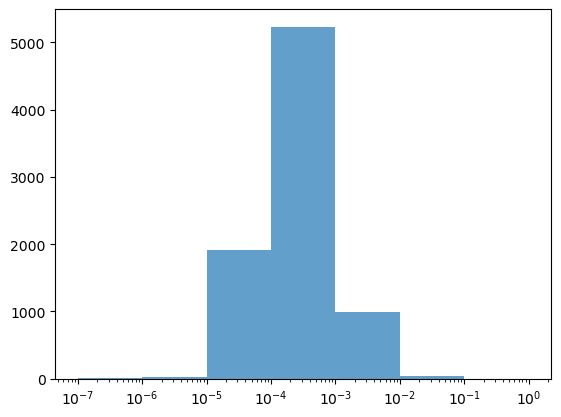

In [ ]:
plt.hist(summary_vector, bins=np.logspace(-7, 0, 8), alpha=0.7)
plt.xscale('log')

We set the cut-off for the TF-IDF values at $10^{-2}$.

In [ ]:
tf_idf_cutoff = 0.01

In [ ]:
tf_idf_filtered = np.where(tf_idf > tf_idf_cutoff, tf_idf, 0.0)

In [ ]:
tf_idf_filtered_summary = tf_idf_filtered.sum(axis=0)

In [ ]:
np.count_nonzero(tf_idf_filtered_summary)

36

At this level, the number of components that are non-zero for at least one document is less than 1000.  We can easily obtain the indices of the salient words in the word vector, and reduce the word vector and the TF-IDF matrix based on those.

In [ ]:
salient_indices = np.nonzero(tf_idf_filtered_summary)[0]

In [ ]:
tf_idf_salient = tf_idf[:, salient_indices]

In [ ]:
tf_idf_salient.shape

(15, 36)

In [ ]:
np.savetxt('data/tf_idf_salient.txt', tf_idf_salient)

In [ ]:
salient_word_vector = np.array(word_vector)[salient_indices]

IndexError: index 7989 is out of bounds for axis 0 with size 4688

In [ ]:
salient_word_vector

In [ ]:
with open('data/salient_word_vector.txt', 'w') as file:
    print('\n'.join(salient_word_vector), file=file)

In [ ]:
tf_idf_salient = np.genfromtxt('data/tf_idf_salient.txt')

In [ ]:
tf_idf_salient.shape

In [ ]:
salient_word_vector = np.genfromtxt('data/salient_word_vector.txt')

In [ ]:
salient_word_vector.shape

# Output

## Data preparation

The output (questions, subquestions, pillars) for each of the documents is stored in a CSV document.

In [ ]:
metadata = pd.read_csv('data/efsa_cs1.csv', encoding='latin1')

In [ ]:
metadata.info()

A classification is available for some documents that are missing from the training data, so we make sure those are dropped from the dataframe.

In [ ]:
metadata_doc_ids = set(metadata.EFSAID)

In [ ]:
doc_ids = set(np.genfromtxt('data/doc_ids.txt'))

In [ ]:
metadata_doc_ids - doc_ids

In [ ]:
doc_ids - metadata_doc_ids

In [ ]:
metadata = metadata[~metadata.EFSAID.isin(metadata_doc_ids - doc_ids)]

In [ ]:
metadata.info()

In [ ]:
metadata = metadata[['EFSAID', 'QuestionID', 'SubQuestionID', 'PillarID']]

In [ ]:
metadata.info()

In [ ]:
metadata.to_csv('data/metadata.csv', index=False)

In [ ]:
metadata = pd.read_csv('data/metadata.csv')

In [ ]:
metadata.info()

The output data for the documents is in a pandas dataframe that contains only positive data.  It would be more convenient to have it in a numpy array that contains either 0 or 1 for each document, depending on whether the document addresses the question/subquestion/pillar.

In [ ]:
def create_output(data, col_name, item_id):
    output_col_name = 'output'
    output = data[['EFSAID', col_name]].drop_duplicates().query(f'{col_name} == {item_id}')
    output.rename(columns={col_name: output_col_name}, inplace=True)
    output.output = 1
    neg_ids = data[~data.EFSAID.isin(output.EFSAID)].EFSAID.unique()
    neg_output = pd.DataFrame({
        'EFSAID': neg_ids,
        output_col_name: [0]*len(neg_ids),
    })
    return pd.concat([output, neg_output], axis=0) \
             .sort_values(by=['EFSAID']) \
             .reset_index(drop=True)

The data has to be split into three parts:
1. training data
1. validation data
1. test data

The training data will be used to determine the decision forest, the validation data will be used to estimate overfitting, and the test data will not be used at all during training.

In [ ]:
def split_indices(output, fraction):
    pos_output_1 = output[output.output == 1].sample(frac=fraction)
    neg_output_1 = output[output.output == 0].sample(frac=fraction)
    output_1 = pd.concat([pos_output_1, neg_output_1], axis=0).sort_values(by=['EFSAID'])
    output_2 = output[~output.EFSAID.isin(output_1.EFSAID)].sort_values(by=['EFSAID'])
    return output_1.index.values, output_2.index.values

In [ ]:
def create_dataset(tf_idf, output_df, indices):
    input = tf_idf[indices, :]
    output = output_df.iloc[indices].output.to_numpy()
    return input, output

In [ ]:
def create_datasets(input_data, output_data, value_name, value,
                    test_frac=0.2, val_frac=0.2, verbose=False):
    value_output = create_output(output_data, value_name, value)
    test_indices, training_indices = split_indices(value_output, test_frac)
    val_indices, train_indices = split_indices(value_output.iloc[training_indices],
                                               val_frac)
    test_input, test_output = create_dataset(input_data, value_output, test_indices)
    np.savetxt(f'data/6-validations/{value_name}_{value}_target_output.txt',
               test_output)
    val_input, val_output = create_dataset(input_data, value_output, val_indices)
    train_input, train_output = create_dataset(input_data, value_output,
                                               train_indices)
    with open('data/6-validations/indices.txt', 'w') as file:
        for index in train_indices:
            print(f'{index},training', file=file)
        for index in val_indices:
            print(f'{index},validation', file=file)
        for index in test_indices:
            print(f'{index},test', file=file)
    if verbose:
        print(f'training data:   {train_input.shape} -> {train_output.shape}', file=sys.stderr)
        print(f'validation data: {val_input.shape} -> {val_output.shape}', file=sys.stderr)
        print(f'test data:       {test_input.shape} -> {test_output.shape}', file=sys.stderr)
    return (
        xgb.DMatrix(train_input, label=train_output),
        xgb.DMatrix(val_input, label=val_output),
        xgb.DMatrix(test_input)
    )

We construct the XGBoost datasets for the training, validation and test examples.

In [ ]:
q1_train_data, q1_val_data, q1_test_data = create_datasets(tf_idf_salient, metadata,
                                                           'QuestionID', 1,
                                                           verbose=True)

480 documents will be used for training, 119 for validation and 149 as test.

## Training

The evaluation list contains the data sets that are evaluated at the end of each training round.  This is the training and validation data as a list of tuples.

In [ ]:
evallist = [(q1_train_data, 'train'), (q1_val_data, 'eval')]

A number of hyperparameters can be specified.
* `max_depth`: increases model complexity, hence potential overfitting.
* `eta`: determines step size, when decreased, increase number of steps.
* `nthread': number of threads to use for the learning process.
* `eval_metric`: metric used to evaluate training and validation sets.

In [ ]:
param = {
    'max_depth': 2,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': 'auc',
}
nr_steps = 100

In order to keep track of the training and validation error, we can define a dictionary to hold that information.

In [ ]:
progress = {}

Train the model.

In [ ]:
bst = xgb.train(param, q1_train_data, nr_steps, evals_result=progress, evals=evallist)

In [ ]:
def save_progress(progress, file_name):
    train_progress = progress['train']['auc']
    eval_progress = progress['eval']['auc']
    time_progress = range(1, len(train_progress) + 1)
    progress_data = np.array([time_progress, train_progress, eval_progress]).transpose()
    np.savetxt(file_name, progress_data)

Now the trained model can be used to predict whether a document answers the question, and we can compare this to the output for the test data.

In [ ]:
q1_pred_output = bst.predict(q1_test_data)

In [ ]:
np.count_nonzero(q1_test_output - q1_pred_output.round(0))/len(q1_test_output)

In [ ]:
bst.save_model('models/q1_model.json')

In [ ]:
bst = xgb.Booster()
bst.load_model('models/q1_model.json')

The importance of features in the model is indicated by the F-scores.  These can be visualized easily.

In [ ]:
xgb.plot_importance(bst, max_num_features=10);

The hyperparameters for the XGBoost algorithm are defined in a dictionary, and these can perhaps be fine-tuned in a later stage.

In [ ]:
param = {
    'max_depth': 2,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': 'auc',
    'verbosity': 0,
}
nr_steps = 100

We need a function to do the training and testing for each of the models we want to create.  This function will
* extract the relevant training data based on the given value name and value,
* train a model and save it to a file,
* save the training progress to a file,
* evaluate the test data and store the results,
* evaluate all the data and store the results.

In [ ]:
def train_eval(input_data, output_data, value_name, value, params, verbose=False):
    train_data, val_data, test_data = create_datasets(input_data, output_data,
                                                      value_name, value,
                                                      verbose=verbose)
    evallist = [(train_data, 'train'), (val_data, 'eval')]
    progress = {}
    bst = xgb.train(param, train_data, nr_steps, evals=evallist,
                    evals_result=progress, verbose_eval=False)
    bst.save_model(f'models/{value_name}_{value}_model.json')
    save_progress(progress, f'data/6-validations/{value_name}_{value}_auc.txt')
    test_output = bst.predict(test_data)
    np.savetxt(f'data/6-validations/{value_name}_{value}_output.txt',
               test_output)
    all_data = xgb.DMatrix(input_data)
    all_output = bst.predict(all_data)
    np.savetxt(f'data/5-predictions/{value_name}_{value}_output.txt',
               all_output)

Create the models and evaluation results for all questions, subquestions and pillars.

In [ ]:
for question_id in metadata.QuestionID.unique():
    train_eval(tf_idf_salient, metadata, 'QuestionID', question_id, param, verbose=False)

In [ ]:
for pillar_id in metadata.PillarID.unique():
    train_eval(tf_idf_salient, metadata, 'PillarID', pillar_id, param)

In [ ]:
for subquestion_id in metadata.SubQuestionID.unique():
    train_eval(tf_idf_salient, metadata, 'SubQuestionID', subquestion_id, param)

## Evaluation

In [ ]:
def evaluate(value_name, value):
    output = np.genfromtxt(f'data/6-validations/{value_name}_{value}_output.txt')
    target_output = np.genfromtxt(f'data/6-validations/{value_name}_{value}_target_output.txt')
    return np.count_nonzero(target_output - output.round(0))/len(output)

In [ ]:
def confustion_matrix(value_name, value):
    output = np.genfromtxt(f'data/6-validations/{value_name}_{value}_output.txt')
    target_output = np.genfromtxt(f'data/6-validations/{value_name}_{value}_target_output.txt')
    df = pd.DataFrame({
        'target': target_output,
        'output': output,
    })
    true_pos_out = len(df[(df.target > 0.5) & (df.output > 0.5)])
    false_pos_out = len(df[(df.target <= 0.5) & (df.output > 0.5)])
    true_neg_out = len(df[(df.target <= 0.5) & (df.output <= 0.5)])
    false_neg_out = len(df[(df.target > 0.5) & (df.output <= 0.5)])
    return [
        [true_pos_out, false_pos_out],
        [false_neg_out, true_neg_out],
    ]

In [ ]:
for question_id in range(1, 11):
    print(confustion_matrix('QuestionID', question_id))

In [ ]:
for pillar_id in range(1, 5):
    print(confustion_matrix('PillarID', pillar_id))

In [ ]:
for subquestion_id in range(1, 400):
    try:
        print(f'{subquestion_id:3d}',
              f'{str(confustion_matrix("SubQuestionID", subquestion_id)):25s}',
              f'{evaluate("SubQuestionID", subquestion_id):6.3f}')
    except:
        pass

In [ ]:
def plot_score(file_name):
    data = np.genfromtxt(file_name, delimiter=',', names=True)
    name = data.dtype.names[0]
    plt.bar(data[name], data['score'])

Write the test scores to a file.

In [ ]:
with open('data/6-validations/test_questions_score.txt', 'w') as file:
    print('question_id,score', file=file)
    for question_id in sorted(metadata.QuestionID.unique()):
        print(f"{question_id:3d},{evaluate('QuestionID', question_id):.3f}", file=file)

In [ ]:
plot_score('data/6-validations/test_questions_score.txt')

In [ ]:
with open('data/6-validations/test_pillars_score.txt', 'w') as file:
    print('pillar_id,score', file=file)
    for pillar_id in sorted(metadata.PillarID.unique()):
        print(f"{pillar_id:3d},{evaluate('PillarID', pillar_id):.3f}", file=file)

In [ ]:
plot_score('data/6-validations/test_pillars_score.txt')

In [ ]:
with open('data/6-validations/test_subquestions_score.txt', 'w') as file:
    print('subquestion_id,score', file=file)
    for subquestion_id in sorted(metadata.SubQuestionID.unique()):
        print(f"{subquestion_id:3d},{evaluate('SubQuestionID', subquestion_id):.3f}", file=file)

In [ ]:
plot_score('data/6-validations/test_subquestions_score.txt')

To visualize the training progress, we need a function to plot the AUC for the training and the validation set.

In [ ]:
def plot_progress(value_name, value):
    progress_data = np.genfromtxt(f'data/6-validations/{value_name}_{value}_auc.txt')
    plt.plot(progress_data[:, 0], progress_data[:, 1], label='training')
    plt.plot(progress_data[:, 0], progress_data[:, 2], label='evaluation')
    plt.xlabel('nr. steps')
    plt.ylabel('AUC')
    plt.ylim(0.0, 1.0)
    plt.legend();

In [ ]:
plot_progress('QuestionID', 3)

In [ ]:
def read_indices(file_name):
    indices = pd.read_csv(file_name, names=['doc_index', 'set_name'])
    return (
        indices[indices.set_name == 'training'].doc_index.tolist(),
        indices[indices.set_name == 'validation'].doc_index.tolist(),
        indices[indices.set_name == 'test'].doc_index.tolist(),
    )

In [ ]:
train_indices, val_indices, test_indices = read_indices('data/6-validations/indices.txt')

In [ ]:
def create_target(metadata):
    targets = []
    for doc in metadata.groupby(['EFSAID']):
        data = {
            'efsa_id': doc[0],
            'questions': set(doc[1].QuestionID),
            'pillars': set(doc[1].PillarID),
            'subquestions': set(doc[1].SubQuestionID),
        }
        targets.append(data)
    return targets

In [ ]:
target_data = create_target(metadata)

In [ ]:
len(target_data)

# Hierarchical models

We know from the analysis of the data that for any two questions, the associated subquestions form disjoint sets, and similar for the subquestions associated with pillars.

In [ ]:
question_subquestions = {group[0]: set(group[1].SubQuestionID)
                         for group in metadata[['QuestionID', 'SubQuestionID']].drop_duplicates().groupby('QuestionID')}

In [ ]:
print(question_subquestions)

In [ ]:
pillar_subquestions = {group[0]: set(group[1].SubQuestionID)
                         for group in metadata[['PillarID', 'SubQuestionID']].drop_duplicates().groupby('PillarID')}

In [ ]:
print(pillar_subquestions)